In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
plt.style.use('dark_background')

## Load the review data set into a Pandas DataFame

In [42]:
filename = './archive/Reviews.csv'
df = pd.read_csv(filename)

## First we examine the distribution of review scores in the data set with a histogram

<AxesSubplot:xlabel='Score', ylabel='Count'>

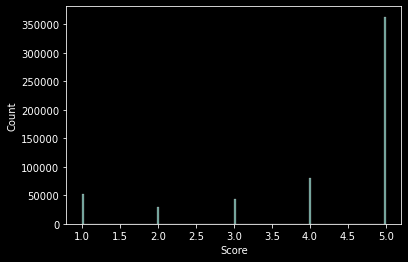

In [4]:
sns.histplot(df.Score)

## A look at the data set's head

In [9]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## We will examine how review length relates to score, but first we must add a new calculated column based on each review's length.

In [4]:
df['text_length'] = df['Text'].str.len()

In [11]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140


## Next we convert Unix time into a datetime that is human readable.

In [5]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

In [13]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,140


## Now we look at how score relates to length with a boxplot.

<AxesSubplot:xlabel='Score', ylabel='text_length'>

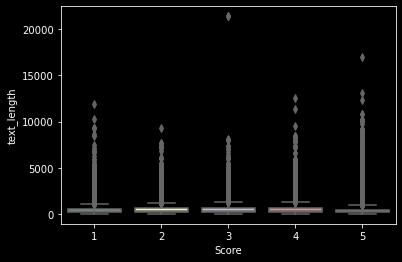

In [18]:
sns.boxplot(x=df.Score, y=df.text_length)

## We will examine the impact of time on review scores next.  First we check the first and last dates in our data set.  Then we will look at how review length changed over time on a lineplot.

In [15]:
df['Time'].min()

Timestamp('1999-10-08 00:00:00')

In [16]:
df['Time'].max()

Timestamp('2012-10-26 00:00:00')

<AxesSubplot:xlabel='Time', ylabel='text_length'>

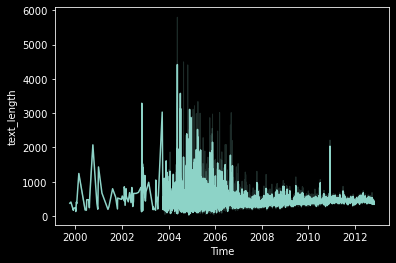

In [24]:
sns.lineplot(x=df.Time, y=df.text_length)

## Now we will prepare a subset of the data which will be used to train our sentiment prediction model.  We first load a csv file where we have already removed all data set columns, except for the review text and the score.

In [5]:
training_df_subset = pd.read_csv("./archive/train_reviews.csv")

In [26]:
training_df_subset.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


## Next since the quantity of reviews with a score of 5 are disproportionate, we equalize the scores and remove excess rows.

In [6]:
g = training_df_subset.groupby('Score')
training_df_subset = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))

In [30]:

training_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 148845 entries, (1, 0) to (5, 29768)
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Score   148845 non-null  int64 
 1   Text    148845 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.7+ MB


## To reduce the data set's size, we will obtain a random sample equal to 50% of the total number of reviews.

In [7]:
training_df_subset = training_df_subset.sample(frac=0.5, replace=True, random_state=1)

In [32]:
training_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74422 entries, (5, 8961) to (4, 12014)
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Score   74422 non-null  int64 
 1   Text    74422 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


## Next we remove all reviews with a score of 3, since we want the model to be trained on more polarized reviews.

In [8]:
training_df_subset = training_df_subset[training_df_subset['Score'] != 3]

## The final step in preparing the data set for training is to normalize the scores.  Since our classifier will only predict whether a review is 1 or 0 (1 being positive, 0 being negative), we will convert all scores >= 4 to 1 & all scores <= 2 to 0.  We will create variable X that will hold a series of the text and Y which will hold a series of corresponding scores.   

In [9]:
X = training_df_subset['Text']
y_map = {5:1, 4:1, 2:0, 1:0}
Y = training_df_subset['Score'].map(y_map)

## Now we will split the data into a training and test sets.  80% of the data will be used for training and 20% for testing.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_Test = train_test_split(X, Y, test_size=0.2)

## Next the text must be vectorized to be used in the machine learning model.  We use Scikit-learns CountVectorizer object to do so.  This will also take care of removing stopwords and other unwanted characters.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

## Now we will downscale the vector using a Term Frequency times Inverse Document Frequency tranformer.

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

## We now import a Multinomial naive Bayes classifier and fit the prepared training data to it.

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [15]:
test_review = ['The product was garbage']

## Now we can test the model and see it's prediction for the test review 

In [16]:
X_new_counts = count_vect.transform(test_review)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
print(clf.predict(X_new_tfidf))

[0]


## Next we build a pipeline to make the vectorizer -> transformer -> classifier easier to handle. 

In [17]:
from sklearn.pipeline import Pipeline
review_clf = Pipeline([
    ('countVect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

## Now we can evaluate the performance of the model with the test data.

In [18]:
review_clf.fit(X_train, Y_train)

predicted = review_clf.predict(X_test)

In [19]:
np.mean(predicted == Y_Test)

0.8586391821685939

## The evaluation shows that the model is correct 86.3% of the time.  We can easily alter the pipeline to adjust parameters, to test if the accuracy can be improved.  We will see if changing the ngram range, which is an optional parameter of the CountVectorizer method, can improve the accuracy.

In [20]:
review_clf = Pipeline([
    ('countVect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [21]:
review_clf.fit(X_train, Y_train)
predicted = review_clf.predict(X_test)

In [22]:
np.mean(predicted == Y_Test)

0.9229931288754818

## Adjust the ngram range to (1,2), which makes features of words of length two to four.  This tends to capture more natural meaning, and improved the model's accuracy by about 7%.

## Finally joblib will be used to serialize the clf_review model object to be used later.

In [23]:
import joblib

In [24]:
joblib.dump(review_clf,'review_clf.joblib')

['review_clf.joblib']

## Here we test using the saved model 

In [25]:
clf_loaded = joblib.load('review_clf.joblib')

In [26]:
clf_loaded.predict(['I love to use this product, it is amazing!'])[0]

1